In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import  torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
from sklearn.cluster import KMeans, MiniBatchKMeans
from statistics import mean
from collections  import OrderedDict
from collections  import namedtuple
import sys

device = torch.device('cuda')

In [2]:
transform = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
}

In [3]:
data_dir = '../datasets/ILSVRC2012_img_val - Retrain/'
dataset = {x:datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train', 'val']}

In [4]:
dataloader = {x:torch.utils.data.DataLoader(dataset[x], batch_size = 512, shuffle = False, pin_memory = True, num_workers = 16)
              for x in ['train', 'val']}

In [8]:
############# Test Code ##############

In [12]:
dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms.ToTensor()) 
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False)

torch.Size([341, 500, 3])
tensor([4])


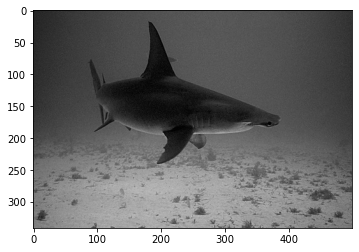

In [17]:
num = 189

obj = iter(dataloader_test)
pos = 0
choice = next(obj)

while pos < num:
    choice = next(obj)
    pos += 1

print(choice[0].squeeze(0).permute(1,2,0).size())
plt.imshow(choice[0].squeeze(0).permute(1,2,0))
print(choice[1])

In [ ]:
#####################################

In [ ]:
dataset_size = {x:len(dataset[x]) for x in ['train', 'val']}
class_names = dataset['train'].classes

In [ ]:
def process(x):
    global epsilon
    non_zero_mask = (x != 0)
    x[non_zero_mask] -= epsilon
    return x 

In [ ]:
class my_conv(nn.Module):
    
    global device
    global epsilon
    
    def __init__(self, wt_layer):
       
        super(my_conv, self).__init__()
        self.weight = process(wt_layer.weight.to(device)) 
        self.bias = wt_layer.bias.to(device)
        self.stride = wt_layer.stride
        self.padding = wt_layer.padding
        #self.dilation = wt_layer.dilation
        #self.groups = wt_layer.groups
        
    def forward(self, x):
        return F.conv2d(process(x), self.weight, bias = self.bias, stride = self.stride, padding = self.padding)

In [ ]:
class my_fc(nn.Module):
    
    global device
    global epsilon
    
    def __init__(self, wt_layer):
        super(my_fc, self).__init__()
        self.weight = process(wt_layer.weight.to(device))
        self.bias = wt_layer.bias.to(device)
        
    def forward(self, x):
        return F.linear(process(x), self.weight, bias = self.bias)
        

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, init_state_dict, num_classes=1000):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        self.load_state_dict(init_state_dict)
        
        self.init_layers()
       
    def init_layers(self):
        
        ind = -1
        q_list = []
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                ind += 1
                q_list.append(my_conv(layer))
            else:
                q_list.append(layer)
        self.features = nn.Sequential(*q_list)
        
        ind = -1
        q_list = []
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                ind += 1
                q_list.append(my_fc(layer))
            else:
                q_list.append(layer)
        self.classifier = nn.Sequential(*q_list)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG16(nn.Module):

    def __init__(self, init_state_dict, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = make_layers(cfgs['D'], batch_norm = False)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
            
        self.load_state_dict(init_state_dict)
        self.init_layers()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def init_layers(self):
        
        ind = -1
        q_list = []
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                ind += 1
                q_list.append(my_conv(layer))
            else:
                q_list.append(layer)
        self.features = nn.Sequential(*q_list)
        
        ind = -1
        q_list = []
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                ind += 1
                q_list.append(my_fc(layer))
            else:
                q_list.append(layer)
        self.classifier = nn.Sequential(*q_list)


In [ ]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG19(nn.Module):

    def __init__(self, init_state_dict, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = make_layers(cfgs['E'], batch_norm = False)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
        self.load_state_dict(init_state_dict)
        self.init_layers()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def init_layers(self):
        
        ind = -1
        q_list = []
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                ind += 1
                q_list.append(my_conv(layer))
            else:
                q_list.append(layer)
        self.features = nn.Sequential(*q_list)
        
        ind = -1
        q_list = []
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                ind += 1
                q_list.append(my_fc(layer))
            else:
                q_list.append(layer)
        self.classifier = nn.Sequential(*q_list)


In [ ]:
def check_accuracy(model, phase):
    
    global device
    
    model.to(device)
    model.eval()
#     if record_grad:
#         model.train()
#     else:
#         model.eval()

        
    done = torch.tensor(0, dtype = torch.int64)
    acc = 0.0
    since = time.time()
    corrects = torch.tensor(0, dtype = torch.int64)
    total_loss = 0.0
    corrects = corrects.to(device)
    loss = 100.0
    
    for inputs, labels in dataloader[phase]:

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels)

        done += len(inputs)
        print('\r{}, {}, {:.2f}%, {:.2f}'.format(corrects.item(), done, corrects.double().item() * 100.0 / done.double(), total_loss), end = '', flush = True)
#         if done >= 1000:
#             break
                    
    acc = corrects.double() / done.double()
    print('\n{} Acc: {:.4f} %'.format(phase, acc * 100))

    time_elapsed = time.time() - since
    print('Total time taken = {} seconds'.format(time_elapsed))

    return acc


In [ ]:
for ecc in [0, 1e-3, 1e-4,  1e-5]:
    epsilon = ecc
    
    alexnet = models.alexnet(pretrained=True).to(device)
    model = AlexNet(init_state_dict= alexnet.state_dict())
    model.to(device)
    torch.cuda.empty_cache()
    acc = check_accuracy(model, 'train')
    
    model = AlexNet(init_state_dict= torch.load('../models/undone_wt_shared_net.pth'))
    model.to(device)
    torch.cuda.empty_cache()
    acc = check_accuracy(model, 'train')
    
    print()

In [ ]:
# for ecc in [0, 1e-2, 1e-3,  1e-4,  1e-5]:
#     epsilon = ecc
    
#     vgg = models.vgg16(pretrained=True).to(device)
#     model = VGG16(init_state_dict= vgg.state_dict())
#     model.to(device)
#     torch.cuda.empty_cache()
#     acc = check_accuracy(model, 'train')

#     with open('D:Desktop/Acc Vals.txt', 'a') as file:
#         file.write('\n' + 'VGG16\t\t' + str(epsilon) + '\t\t' + str(acc.item() * 100) + '%')

In [ ]:
# for ecc in [0, 1e-2, 1e-3,  1e-4,  1e-5]:
#     epsilon = ecc
    
#     vgg = models.vgg19(pretrained=True).to(device)
#     model = VGG19(init_state_dict= vgg.state_dict())
#     model.to(device)
#     torch.cuda.empty_cache()
#     acc = check_accuracy(model, 'train')

In [ ]:
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################